In [19]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

#Code implementations derived from https://github.com/mimoralea/gdrl

# Policy Gradient

- In policy-based deep reinforcement learning, we aim to *maximize* the performance of a parameterized policy: the expected return from the initial state, which is the expected value function from all initial states. Policy gradient approaches this through *gradient ascent*.
  - $J_i(\theta_i) = \mathbb{E}_{s_0\sim p_0}[v_{\pi _{\theta _i}}(s_0)]$
- Advantages of learning parameterized policies include:
  - policy can be any learnable function
  - effective in high-dimensional/continuous action spaces
  - can more easily learn stochastic policies; better performance under partially observable environments
  - can be easier, more generalizable than value function approximation
  - better convergence properties
- The basic policy gradient is:
  - $$\nabla_\theta J(\theta) = \nabla_\theta\mathbb{E}_{\tau\sim\pi_\theta}\left[G(t)\right]=\sum_{\tau\sim\pi_\theta}\nabla_\theta P(\tau|\theta)G(\tau)$$
  - where for all possible trajectories generated by the policy ($\tau\sim\pi_\theta$), the gradient of the probability of the trajectory can be derived from the gradient of its log-probability (*score function gradient estimator*). This leads to the following:
  - $$\nabla_\theta J(\theta)=\mathbb{E}_{\tau\sim\pi_\theta}\left[\nabla_\theta\log P(\tau|\theta)G(t)\right]=\mathbb{E}_{\tau\sim\pi_\theta}\left[\sum_{t=0}^T \nabla_\theta\log \pi_\theta(A_t|S_t)G(\tau) \right]$$

## Discrete-action stochastic policy neural network

- Output layer represents the logits of actions for a given state
- Convert to categorical probability distribution using softmax activation
  - Select action by sampling this distribution
  - Log-probability of selected action ($\log\pi_\theta(A_t|S_t)$) used for gradient ascent

In [20]:
class FCDAP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), #define hidden layers as tuple where each element is an int representing # of neurons at a layer
                 activation_fc=nn.ReLU):
        super(FCDAP, self).__init__()
        self.activation_fc = activation_fc

        hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            hidden_layers.append(activation_fc())
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            activation_fc(),
            *hidden_layers,
            nn.Linear(hidden_dims[-1], output_dim)
        )

        device = "cpu"
        #if torch.cuda.is_available():
        #    device = "cuda"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
        
    def forward(self, state):
        x = self._format(state)
        return self.layers(x)

    #select and return action, corresponding log prob of the action, and entropy of the distribution
    def select_action(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action).unsqueeze(-1), dist.entropy().unsqueeze(-1)

## REINFORCE: The simplest policy gradient algorithm

- Each epoch consists of a number of episodes in set $E$
  - For each episode:
    - Generate full trajectory $\tau$ with policy $\pi_\theta$
    - For each experience $(S_t, A_t, R_{t+1}, S_{t+1})$:
      - Get log-probability of the selected action, $\log\pi_\theta(A_t|S_t)$
      - Calculate return: $G_t(\tau)$
    - Apply gradient descent using the below expression ("reward-to-go" policy gradient):
    - $$\frac{1}{|E|}\sum_{e\in E}\sum_{t=0}^T \log \pi_\theta(A_t|S_t)G_t(\tau)$$

In [21]:
class REINFORCE():
    def __init__(self, 
                policy_model_fn = lambda num_obs, nA: FCDAP(num_obs, nA), #state vars, nA -> model
                policy_optimizer_fn = lambda params, lr : optim.Adam(params, lr), #model params, lr -> optimizer
                policy_optimizer_lr = 1e-4, #optimizer learning rate
                ):
        self.policy_model_fn = policy_model_fn
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr

    def _init_model(self, env, lr=None):
        if not lr:
            lr = self.policy_optimizer_lr
        #initialize policy model
        self.policy_model = self.policy_model_fn(len(env.observation_space.sample()), env.action_space.n)
        #initialize optimizer
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model.parameters(), lr=lr)
    
    def _optimize_model(self, rewards, log_probs):
        T = len(rewards)
        #calculate returns G_t(tau)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = torch.FloatTensor([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)]).unsqueeze(1)
        log_probs = torch.cat(log_probs)
        
        #calculate "policy loss" as the negative policy gradient
        policy_loss = -(returns * log_probs).mean()

        #optimize step (gradient descent)
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
    
    def train(self, env, gamma=1.0, num_episodes=100, lr=None, save_models=None):
        if save_models: #list of episodes to save models
                save_models.sort()
        self.gamma = gamma
        self._init_model(env, lr)

        saved_models = {}
        best_model = None

        i = 0
        episode_returns = np.zeros(num_episodes)
        for episode in tqdm(range(num_episodes)):
            state = env.reset()[0]
            ep_return = 0
            log_probs, rewards = [], []
            for t in count():
                i += 1
                action, log_prob, _ = self.policy_model.select_action(state) #select action and get corresponding log prob
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                #gather log probs and rewards to calculate policy gradient
                log_probs.append(log_prob)
                rewards.append(reward)

                state = next_state

                ep_return += reward * gamma**t #add discounted reward to return
                if terminated or truncated:
                    #save best model
                    if ep_return >= episode_returns.max():
                        copy = self.policy_model_fn(len(env.observation_space.sample()), env.action_space.n)
                        copy.load_state_dict(self.policy_model.state_dict())
                        best_model = copy
                    #copy and save model
                    if save_models and len(saved_models) < len(save_models) and episode+1 == save_models[len(saved_models)]:
                        copy = self.policy_model_fn(len(env.observation_space.sample()), env.action_space.n)
                        copy.load_state_dict(self.policy_model.state_dict())
                        saved_models[episode+1] = copy

                    episode_returns[episode] = ep_return
                    break
            #apply gradient optimization at end of each episode
            self._optimize_model(rewards, log_probs)
        
        return episode_returns, best_model, saved_models


## VPG: REINFORCE with baseline

- While REINFORCE works well in simple problems and has convergence guarentees, it has high variance due to the use of full Monte Carlo returns
- In **VPG**, use state-value function (network) approximation as baseline
  - Update value network weights at each step
  - By subtracting calculated returns by the value of a state, we get an approximation of the action-advantage function
  - Somewhat centers scores around zero

### Encouraging exploration with entropy

- *Entropy* is a measure that can describe the uncertainty, or the amount of information that can be gained by sampling from a distribution
- Adding weighted entropy term to the policy gradient during gradient ascent can help encourage exploration and possibly prevent the model from being stuck at a local maximum

In [22]:
#Fully-connected value network (state observation -> state value)
class FCV(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_dims=(32,32), #define hidden layers as tuple where each element is an int representing # of neurons at a layer
                 activation_fc=nn.ReLU):
        super(FCV, self).__init__()

        hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            hidden_layers.append(activation_fc())
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            activation_fc(),
            *hidden_layers,
            nn.Linear(hidden_dims[-1], 1)
        )

        device = "cpu"
        #if torch.cuda.is_available():
        #    device = "cuda"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        return self.layers(x)

In [23]:
class VPG():
    def __init__(self, 
                policy_model_fn = lambda num_obs, nA: FCDAP(num_obs, nA), #state vars, nA -> model
                policy_optimizer_fn = lambda params, lr : optim.Adam(params, lr), #model params, lr -> optimizer
                policy_optimizer_lr = 1e-4, #optimizer learning rate
                value_model_fn = lambda num_obs: FCV(num_obs), #state vars  -> model
                value_optimizer_fn = lambda params, lr : optim.Adam(params, lr), #model params, lr -> optimizer
                value_optimizer_lr = 1e-4, #optimizer learning rate
                entropy_weight = 1e-4
                ):
        self.policy_model_fn = policy_model_fn
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.entropy_weight = entropy_weight

    def _init_model(self, env, policy_lr=None, value_lr=None):
        if not policy_lr:
            policy_lr = self.policy_optimizer_lr
        if not value_lr:
            value_lr = self.value_optimizer_lr

        self.policy_model = self.policy_model_fn(len(env.observation_space.sample()), env.action_space.n)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model.parameters(), lr=policy_lr)

        self.value_model = self.value_model_fn(len(env.observation_space.sample()))
        self.value_optimizer = self.value_optimizer_fn(self.value_model.parameters(), lr=value_lr)
    
    def _optimize_model(self, rewards, values, log_probs, entropies):
        T = len(rewards)
        #calculate returns G_t(tau)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = torch.FloatTensor([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)]).unsqueeze(1)
        log_probs = torch.cat(log_probs)
        entropies = torch.cat(entropies)
        values = torch.cat(values)

        #calculate "policy loss" as the negative policy gradient with weighted entropy
        advantages = returns - values #use advantage estimates (A_t = G_t-V(S_t)) instead of returns for policy gradient
        policy_grad = (advantages.detach() * log_probs).mean()
        policy_loss = -(policy_grad + self.entropy_weight*entropies.mean())

        #optimize policy network (gradient descent)
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        #optimize value network
        value_loss = advantages.pow(2).mul(0.5).mean() #mean square error
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
    
    def train(self, env, gamma=1.0, num_episodes=100, policy_lr=None, value_lr=None, save_models=None):
        if save_models: #list of episodes to save models
                save_models.sort()
        self.gamma = gamma
        self._init_model(env, policy_lr, value_lr)

        saved_models = {}
        best_model = None

        i = 0
        episode_returns = np.zeros(num_episodes)
        for episode in tqdm(range(num_episodes)):
            state = env.reset()[0]
            ep_return = 0
            log_probs, rewards, values, entropies = [], [], [], []
            for t in count():
                i += 1
                action, log_prob, entropy = self.policy_model.select_action(state) #select action and get corresponding log prob and dist entropy
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                #gather log probs, rewards, and entropies to calculate policy gradient
                log_probs.append(log_prob)
                rewards.append(reward)
                entropies.append(entropy)
                #get estimated value of current state
                values.append(self.value_model(state))

                state = next_state

                ep_return += reward * gamma**t #add discounted reward to return
                if terminated or truncated:
                    #save best model
                    if ep_return >= episode_returns.max():
                        copy = self.policy_model_fn(len(env.observation_space.sample()), env.action_space.n)
                        copy.load_state_dict(self.policy_model.state_dict())
                        best_model = copy
                    #copy and save model
                    if save_models and len(saved_models) < len(save_models) and episode+1 == save_models[len(saved_models)]:
                        copy = self.policy_model_fn(len(env.observation_space.sample()), env.action_space.n)
                        copy.load_state_dict(self.policy_model.state_dict())
                        saved_models[episode+1] = copy

                    episode_returns[episode] = ep_return
                    break
            #apply gradient optimization at end of each episode
            self._optimize_model(rewards, values, log_probs, entropies)
        
        return episode_returns, best_model, saved_models

# Demos

In [24]:
def run_discrete_policy_model(env, model, gamma=1.0, num_episodes=1, stochastic=True):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset()[0]
        for t in count():
            if stochastic:
                action = model.select_action(state)[0]
            else:
                action = model(state).detach().max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

In [25]:
env = gym.make('CartPole-v1')

reinforce = REINFORCE(policy_model_fn= lambda num_obs, nA: FCDAP(num_obs, nA, hidden_dims=(128, 128)))
vpg = VPG(policy_model_fn= lambda num_obs, nA: FCDAP(num_obs, nA, hidden_dims=(128, 128)),
          value_model_fn=lambda num_obs: FCV(num_obs, hidden_dims=(512, 128)))

print('Training REINFORCE...')
r_episode_returns, r_best_model, _ = reinforce.train(env, num_episodes=1000, lr=5e-4)
print('Training VPG...')
vpg_episode_returns, vpg_best_model, _ = vpg.train(env, num_episodes=1000, policy_lr=5e-4, value_lr=5e-4)

Training REINFORCE...


100%|██████████| 1000/1000 [01:52<00:00,  8.92it/s]


Training VPG...


100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


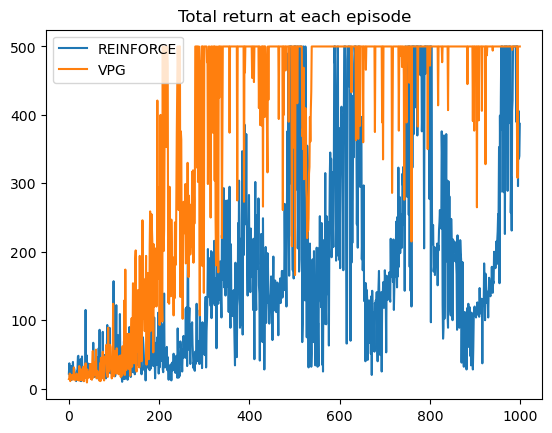

In [26]:
plt.title('Total return at each episode')
plt.plot(range(len(r_episode_returns)), r_episode_returns, label='REINFORCE')
plt.plot(range(len(vpg_episode_returns)), vpg_episode_returns, label='VPG')
plt.legend()

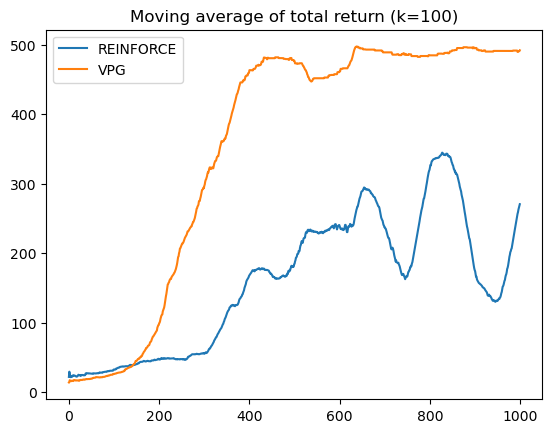

In [27]:
plt.title('Moving average of total return (k=100)')
plt.plot(range(len(r_episode_returns)), [np.mean(r_episode_returns[max(0,x-100):x+1]) for x in range(len(r_episode_returns))], label='REINFORCE')
plt.plot(range(len(vpg_episode_returns)), [np.mean(vpg_episode_returns[max(0,x-100):x+1]) for x in range(len(vpg_episode_returns))], label='VPG')
plt.legend()

In [16]:
env = gym.make('CartPole-v1', render_mode='human')
run_discrete_policy_model(env, r_best_model, num_episodes=1)

[400.0]

In [32]:
env = gym.make('CartPole-v1', render_mode='human')
run_discrete_policy_model(env, vpg_best_model, num_episodes=1, stochastic=True)

[500.0]

In [33]:
env.close()